In [1]:
import numpy as np 
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pickle 

### Prepare data

In [4]:
data_path = "expert_data/human_demos_4_-111.0.pkl"

with open(data_path, 'rb') as f:
    trajs = pickle.load(f)

len(trajs)

4

In [5]:
states=[]
actions=[]
for traj in trajs:
    for state,action in traj:
        states.append(state)
        actions.append(action)

states=np.array(states)
actions=np.array(actions)

states.shape,actions.shape

((438, 2), (438,))

In [6]:
num_classes = np.max(actions)+1 
num_classes

3

In [7]:
data_loader = torch.utils.data.DataLoader( list(zip(states, actions)), batch_size=64, shuffle=True)

batch=next(iter(data_loader))
states,actions = batch
states.shape,actions.shape

(torch.Size([64, 2]), torch.Size([64]))

### Training

In [8]:
class BcNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(BcNet, self).__init__()
        self.layer1 = nn.Linear(state_dim, 64)
        self.layer2 = nn.Linear(64, 32) 
        self.layer3 = nn.Linear(32, action_dim)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x)) 
        x = self.layer3(x)
        # x = F.softmax(x, dim=1)
        return x

In [9]:
bc= BcNet(2, 3)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(bc.parameters(), lr = learning_rate)

In [10]:
loss_list = []  
n_epoch = 250
 
for itr in range(0, n_epoch+1):
    for batch_states, batch_actions in data_loader:
        y_pred = bc(batch_states)
        loss = criterion(y_pred, batch_actions)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    if itr % 10 == 0:
        print(f'iteration: {itr}, loss: {loss.item()}')

iteration: 0, loss: 0.7689721584320068
iteration: 10, loss: 0.5345796346664429
iteration: 20, loss: 0.19051086902618408
iteration: 30, loss: 0.07837319374084473
iteration: 40, loss: 0.17635640501976013
iteration: 50, loss: 0.24099349975585938
iteration: 60, loss: 0.025140205398201942
iteration: 70, loss: 0.07009218633174896
iteration: 80, loss: 0.07251017540693283
iteration: 90, loss: 0.04708259925246239
iteration: 100, loss: 0.10081116110086441
iteration: 110, loss: 0.06338004022836685
iteration: 120, loss: 0.14501109719276428
iteration: 130, loss: 0.03836975246667862
iteration: 140, loss: 0.052079860121011734
iteration: 150, loss: 0.04211452603340149
iteration: 160, loss: 0.04457678273320198
iteration: 170, loss: 0.05283202603459358
iteration: 180, loss: 0.22411932051181793
iteration: 190, loss: 0.0574699230492115
iteration: 200, loss: 0.11252237111330032
iteration: 210, loss: 0.015588926151394844
iteration: 220, loss: 0.025985393673181534
iteration: 230, loss: 0.06850928068161011
it

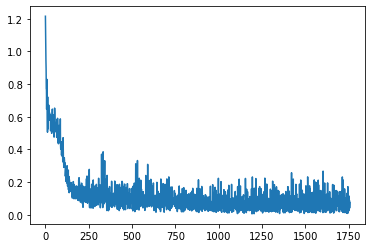

In [11]:
plt.plot(loss_list)

In [12]:
bc.eval()
train_x=torch.tensor(states).float()
train_y=torch.tensor(actions).long()
with torch.no_grad():
    y_pred = bc(train_x)
    correct = (torch.argmax(y_pred, dim=1) == train_y ).type(torch.FloatTensor)
    print('training accuracy: ', correct.mean())

training accuracy:  tensor(1.)


/tmp/ipykernel_66457/906997886.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x=torch.tensor(states).float()
/tmp/ipykernel_66457/906997886.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y=torch.tensor(actions).long()


### Inference

In [13]:
env_name='MountainCar-v0'
env = gym.make(env_name)
env.action_space

Discrete(3)

In [14]:
def play_an_episode(env_name, model, render=False, max_step=500):
    model.eval()
    if render:
        env=gym.make(env_name, render_mode='human')
    else:
        env = gym.make(env_name)
    total_reward=0  
    state,_=env.reset() 
    for i in range(max_step):
        if render: env.render()
        obs=torch.tensor(state).float()
        predict=model(obs)
        action=torch.argmax(predict).item() 
        next_state,reward,done,trunc,info=env.step( action )
        total_reward+=reward
        state=next_state
        if done or trunc: break 
            
    env.close()
    return total_reward

In [15]:
r=play_an_episode(env_name, bc, render=True)
r

-112.0

In [16]:
rewards=[]
n=20
for i in range(n):
    r=play_an_episode(env_name, bc)
    rewards.append(r)
    print(f'episode {i}, reward: {r}')

r_mean=np.mean(rewards)
r_std=np.std(rewards)
print(f'mean reward: {r_mean}, std: {r_std}')

episode 0, reward: -114.0
episode 1, reward: -115.0
episode 2, reward: -114.0
episode 3, reward: -112.0
episode 4, reward: -200.0
episode 5, reward: -112.0
episode 6, reward: -116.0
episode 7, reward: -117.0
episode 8, reward: -120.0
episode 9, reward: -114.0
episode 10, reward: -121.0
episode 11, reward: -111.0
episode 12, reward: -128.0
episode 13, reward: -112.0
episode 14, reward: -116.0
episode 15, reward: -112.0
episode 16, reward: -114.0
episode 17, reward: -113.0
episode 18, reward: -112.0
episode 19, reward: -115.0
mean reward: -119.4, std: 18.898148057415572
